In [1]:
import tensorflow as tf
import numpy as np

from src.common.analysis_and_plots import Visualize as V
from src.features.build_features import FeatureEngineering as FE
from src.common.globals import G
from src.common.globals import split_train_valid_test, get_naive_forecast, calc_errors, save_errors_to_table
from src.data.get_data import CSVsLoader
from src.common.logs import setup_logging, log_model_info

import logging
import os
from datetime import datetime

logger = setup_logging(logger_name=__name__,
                        console_level=logging.INFO, 
                        log_file_level=logging.INFO)

PROJECT_PATH = G.get_project_root()
DATA_DIR_PROCESSED = os.path.join(PROJECT_PATH, r'data\03_processed\daily_full')

config = {
    'AV': {
        'key': '',
        'ticker': 'MSFT',
        'outputsize': 'full',
        'key_adjusted_close': 'Adj Close',
        'key_volume': 'Volume',
    },
    'data': {
        'test_size': 0.05,
    }, 
    'model': {
        'name': 'LSTM', 
        'window': 20,
        'batch_size' : 32,
        'shuffle_buffer_size' : 1000, # https://www.tensorflow.org/api_docs/python/tf/data/Dataset#shuffle
        'epochs' : 30,
        'optimizer': tf.keras.optimizers.Adam(),
        'loss': tf.keras.losses.MeanSquaredError(),
    },
}

In [2]:
def label_column_to_end(df, last_column):
    ''' 
    Changes positions of columns in df to put the target column at the end

    Args:
        df (pandas dataframe) - dataframe to change
        last_column (string) - name of the column to put at the end
        
    Returns:
        df (pandas dataframe) - dataframe with the target column at the end
    '''
    cols = df.columns.tolist()
    cols.remove(last_column)
    cols.append(last_column)
    return df[cols]

In [3]:
def windowed_dataset(df, window_size, batch_size, shuffle_buffer, verbose=True):
    """Generates dataset windows

    Args:
    series (array of float) - contains the values of the time series
    window_size (int) - the number of time steps to include in the feature
    batch_size (int) - the batch size
    shuffle_buffer(int) - buffer size to use for the shuffle method

    Returns:
    dataset (TF Dataset) - TF Dataset containing time windows
    """
    # change the position of the target column to the end
    df = label_column_to_end(df, 'Adj Close')
    
    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(df)
    if verbose:
        print('--------------------------from_tensor_slices--------------------------')
        for element in dataset:
            print(element)
            break
        print('-'*100)

    # Window the data but only take those with the specified size
    # And add + 1 to the window size to account for the label, which we will separate later
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    if verbose:
        print('-------------------------------window-----------------------------------')
        for window in dataset:
            for element in window:
                print(element)
            break
        print('-'*100)
    
    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    if verbose:
        print('--------------------------------flat_map--------------------------------')
        for window in dataset:
            print(window)
            break
        print('-'*100)

    # Create tuples with features and labels
    dataset = dataset.map(lambda window: (window[:-1], window[-1][-1]))
    if verbose:
        print('------------.map(lambda window: (window[:-1], window[-1][-1]))--------------')
        for x,y in dataset:
            print(x, y)
            break
        print('-'*100)

    # Shuffle the windows
    dataset = dataset.shuffle(shuffle_buffer)

    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)
    if verbose:
        print('--------------------------------batch-----------------------------------')
        for x,y in dataset:
            print(x.numpy(), y.numpy())
            break
        print('-'*100)

    return dataset

In [4]:
# -----------------------------Data----------------------------------------
df = CSVsLoader(ticker=config['AV']['ticker'], directory=DATA_DIR_PROCESSED)

test_size_int = int(len(df) * config['data']['test_size'])
df_train = df.iloc[:-test_size_int].copy(deep=True)
df_test = df.iloc[-test_size_int:].copy(deep=True)

# Normalize data with MinMaxScaler()
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
for col in df_train.columns:
    df_train[col] = scaler.fit_transform(df_train[col].values.reshape(-1,1))

train_dataset = windowed_dataset(df_train, 
                                window_size=config['model']['window'], 
                                batch_size=config['model']['batch_size'], 
                                shuffle_buffer=config['model']['shuffle_buffer_size'])

2023-09-19 23:35:36 - src.data.get_data - INFO - Loaded "..\P7-Trading-Bot\data\03_processed\daily_full\MSFT-daily-full.csv". Number data points 5995. From "1999-11-01 00:00:00" to "2023-08-29 00:00:00"


--------------------------from_tensor_slices--------------------------
tf.Tensor([0.0355088  0.05339881], shape=(2,), dtype=float64)
----------------------------------------------------------------------------------------------------
-------------------------------window-----------------------------------
tf.Tensor([0.0355088  0.05339881], shape=(2,), dtype=float64)
tf.Tensor([0.02960297 0.05358007], shape=(2,), dtype=float64)
tf.Tensor([0.0280377  0.05304583], shape=(2,), dtype=float64)
tf.Tensor([0.03634458 0.05280732], shape=(2,), dtype=float64)
tf.Tensor([0.04995357 0.05262606], shape=(2,), dtype=float64)
tf.Tensor([0.19832283 0.05108055], shape=(2,), dtype=float64)
tf.Tensor([0.08379013 0.05005975], shape=(2,), dtype=float64)
tf.Tensor([0.04928543 0.04839022], shape=(2,), dtype=float64)
tf.Tensor([0.04919076 0.05077526], shape=(2,), dtype=float64)
tf.Tensor([0.0322219  0.05036504], shape=(2,), dtype=float64)
tf.Tensor([0.03022788 0.04827574], shape=(2,), dtype=float64)
tf.Tensor([

In [5]:
# -----------------------------Model Architecture--------------------------
model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(128, activation="relu", input_shape=[config['model']['window'], 2]),
        tf.keras.layers.Dense(64, activation="relu"),
        tf.keras.layers.Dense(32, activation="relu"),
        tf.keras.layers.Dense(1),
        ],
    name=config['model']['name'])

model._name = f"{model._name}_{str(model.count_params())}_{datetime.now().strftime('%Y-%m-%d--%H-%M')}"
log_model_info(config, model, logger)

2023-09-19 23:35:36 - __main__ - INFO - ==============================================================================================
2023-09-19 23:35:36 - __main__ - INFO - =================================== MODEL CONFIG AND SETUP ===================================
2023-09-19 23:35:36 - __main__ - INFO - ==============================================================================================
2023-09-19 23:35:36 - __main__ - INFO - AV_key: , AV_ticker: MSFT, AV_outputsize: full, AV_key_adjusted_close: Adj Close, AV_key_volume: Volume, 
2023-09-19 23:35:36 - __main__ - INFO - data_test_size: 0.05, 
2023-09-19 23:35:36 - __main__ - INFO - ----------------------------------------------------------------------
2023-09-19 23:35:36 - __main__ - INFO - model_name: LSTM
2023-09-19 23:35:36 - __main__ - INFO - model_window: 20
2023-09-19 23:35:36 - __main__ - INFO - model_batch_size: 32
2023-09-19 23:35:36 - __main__ - INFO - model_shuffle_buffer_size: 1000
2023-09-19 23:35:36 - __main

Epoch 1/30
178/178 [==============================] - 2s 8ms/step - loss: 0.0232 - mae: 0.0837
Epoch 2/30
178/178 [==============================] - 1s 3ms/step - loss: 0.0278 - mae: 0.1017
Epoch 3/30
178/178 [==============================] - 1s 3ms/step - loss: 0.0266 - mae: 0.0982
Epoch 4/30
178/178 [==============================] - 1s 3ms/step - loss: 0.0277 - mae: 0.1035
Epoch 5/30
178/178 [==============================] - 1s 3ms/step - loss: 0.0303 - mae: 0.1076
Epoch 6/30
178/178 [==============================] - 1s 3ms/step - loss: 0.0301 - mae: 0.1066
Epoch 7/30
178/178 [==============================] - 1s 3ms/step - loss: 0.0340 - mae: 0.1145
Epoch 8/30
178/178 [==============================] - 1s 3ms/step - loss: 0.0296 - mae: 0.1076
Epoch 9/30
178/178 [==============================] - 1s 3ms/step - loss: 0.0348 - mae: 0.1143
Epoch 10/30
178/178 [==============================] - 1s 3ms/step - loss: 0.0334 - mae: 0.1151
Epoch 11/30
178/178 [============================

2023-09-19 23:35:56 - src.common.analysis_and_plots - INFO - Plot "LSTM-MAE_and_Loss-2023-09-19_23-35-56-2.png" saved to "D:\Study 2018 and later\Mignimind Bootcamp\Code\P7-Trading-Bot\figures\LSTM-MAE_and_Loss-2023-09-19_23-35-56-2.png"


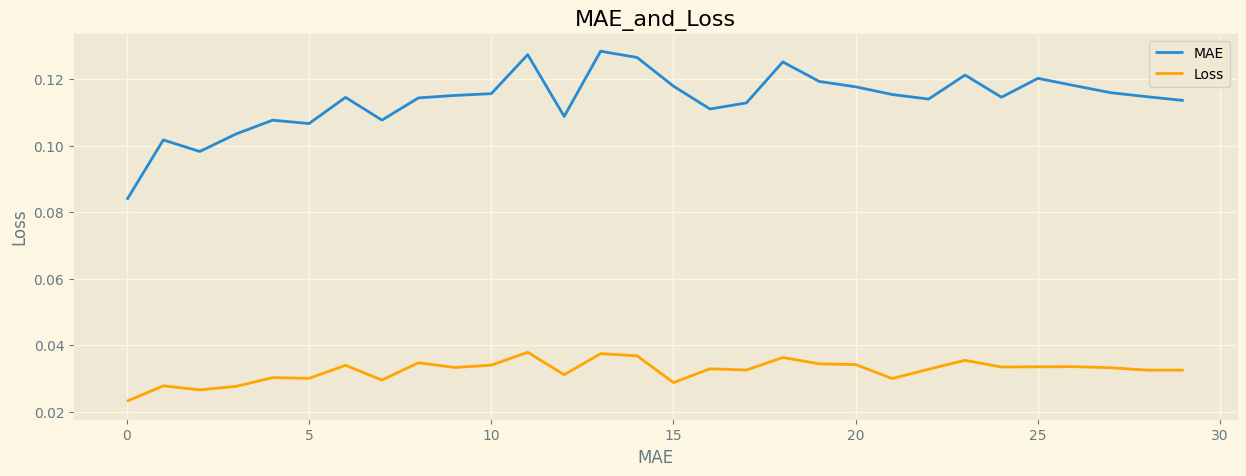

2023-09-19 23:35:56 - __main__ - INFO - Model saved as LSTM_10753_2023-09-19--23-35.h5


In [6]:
# Set the training parameters and train the model
model.compile(loss=config['model']['loss'], 
            optimizer=config['model']['optimizer'], 
            metrics=["mae"],
            )    

# Train the model
history = model.fit(train_dataset, epochs=config['model']['epochs'])

# Plot MAE and Loss
mae=history.history['mae']
loss=history.history['loss']
zoom = int(len(mae) * 1)
V.plot_series(x=range(config['model']['epochs'])[-zoom:],
                y=(mae[-zoom:],loss[-zoom:]),
                model_name=config['model']['name'],
                title='MAE_and_Loss',
                xlabel='MAE',
                ylabel='Loss',
                legend=['MAE', 'Loss']
            )

# Save the model
FE.model_save(model, logger)

In [7]:
def model_forecast(model, series, window_size, batch_size):
    # calculate actual prediction size 
    prediction_size = len(series) - window_size
    print('prediction_size', prediction_size)

    # calculate number of points we need to add to make series evenly divisible by window_size
    remainder = prediction_size % window_size
    remainder = window_size - remainder if remainder > 0 else 0
    print('remainder', remainder)

    # get last prediction_size + remainder points from series
    series = series[-(prediction_size + remainder):]
    print('Paddded series to predict on', series)

    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)
    print('--------------------------from_tensor_slices--------------------------')
    for i,element in enumerate(dataset):
        print(element)
        print(i)
    print('-'*100)

    # Batch the data to window size
    dataset = dataset.batch(window_size)
    print('--------------------------------Batch to window size--------------------------------')
    for i,x in enumerate(dataset):
        print(i,x)
    print('-'*100)


    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)
    print('--------------------------------Batch to Batch size-----------------------------------')
    for x in dataset:
        print(x)
        break
    print('-'*100)
  
    # Get predictions on the entire dataset
    forecast = model.predict(dataset)
    print('--------------------------------forecast-----------------------------------')
    for i,x in enumerate(forecast):
        if i > 1:
            break
        print(i,x)
    print('-'*100)

    forecast = forecast.squeeze()

    # flatten the forecast array
    forecast = forecast.flatten()
    # get the last prediction_size points
    forecast = forecast[-prediction_size:]

    return forecast

prediction_size 299
remainder 1
Paddded series to predict on              Adj Close    Volume
Date                            
2022-06-21  250.778474  29928297
2022-06-22  250.175593  25961215
2022-06-23  255.838716  25861449
2022-06-24  264.575540  33923231
2022-06-27  261.798337  24615114
...                ...       ...
2023-08-23  327.000000  21166382
2023-08-24  319.970000  23281434
2023-08-25  322.980000  21684104
2023-08-28  323.700000  14808482
2023-08-29  328.410000  19284590

[300 rows x 2 columns]
--------------------------from_tensor_slices--------------------------
tf.Tensor([2.50778474e+02 2.99282970e+07], shape=(2,), dtype=float64)
0
tf.Tensor([2.50175593e+02 2.59612150e+07], shape=(2,), dtype=float64)
1
tf.Tensor([2.55838716e+02 2.58614490e+07], shape=(2,), dtype=float64)
2
tf.Tensor([2.6457554e+02 3.3923231e+07], shape=(2,), dtype=float64)
3
tf.Tensor([2.61798337e+02 2.46151140e+07], shape=(2,), dtype=float64)
4
tf.Tensor([2.53486494e+02 2.73802470e+07], shape=(2,), dt

2023-09-19 23:35:56 - src.common.analysis_and_plots - INFO - Plot "LSTM-None-2023-09-19_23-35-56-8.png" saved to "D:\Study 2018 and later\Mignimind Bootcamp\Code\P7-Trading-Bot\figures\LSTM-None-2023-09-19_23-35-56-8.png"


--------------------------------forecast-----------------------------------
0 [[1912798.5]
 [1659249.8]
 [1652873. ]
 [2168126.2]
 [1573215.8]
 [1749944.5]
 [1282713.2]
 [2028006.1]
 [1459615. ]
 [1468175.5]
 [1522679.8]
 [1333206.2]
 [1256438.9]
 [1247514. ]
 [2292451.5]
 [1885259. ]
 [1604387.2]
 [1902939.9]
 [1340567.2]
 [1598618. ]]
1 [[1456457.2]
 [1431939.5]
 [1398488.5]
 [1345742. ]
 [2514838.2]
 [2939610.8]
 [2138476.5]
 [2054968.9]
 [1376647.8]
 [1454277.1]
 [1503150.6]
 [1156728. ]
 [1072103.2]
 [1198856.8]
 [1495887.8]
 [1577863. ]
 [1282462.8]
 [1445679.6]
 [1155895.8]
 [1156997.4]]
----------------------------------------------------------------------------------------------------
(299,)


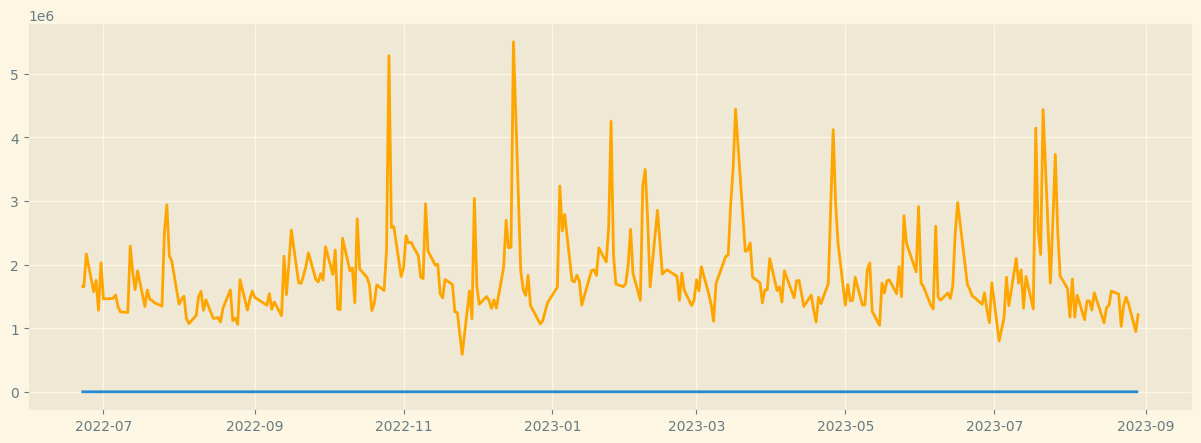

In [8]:
# -----------------------------Predictions---------------------------------
forecast_series = df.iloc[-test_size_int - config['model']['window']:]

results = model_forecast(model=model, 
                            series=forecast_series, 
                            window_size=config['model']['window'], 
                            batch_size=config['model']['batch_size'])
print(results.shape)
# unnormalize the data
# results = scaler.inverse_transform(results.reshape(-1,1))

V.plot_series(  x=df_test.index, 
                y=(df_test['Adj Close'], results),
                model_name=config['model']['name'])

In [9]:
# -----------------------Calculate Errors----------------------------------
naive_forecast = get_naive_forecast(df).iloc[-len(df_test['Adj Close']):]
rmse, mae, mape, mase = calc_errors(df_test['Adj Close'], results, naive_forecast)
save_errors_to_table(config['model']['name'], {'rmse': rmse, 'mae': mae, 'mape': mape, 'mase': mase})

2023-09-19 23:35:57 - src.common.globals - INFO - Test RMSE: $ 1932861.552
2023-09-19 23:35:57 - src.common.globals - INFO - Test MAE : $ 1814283.232
2023-09-19 23:35:57 - src.common.globals - INFO - Test MAPE:   6750.113
2023-09-19 23:35:57 - src.common.globals - INFO - Test MASE:   464890.092
2023-09-19 23:35:57 - src.common.globals - INFO - Errors saved to for LSTM model to "logs/models_table.csv" file.
